In [1]:
import numpy as np
import matplotlib.pyplot as plt
# sudo apt-get install msttcorefonts -qq
# rm ~/.cache/matplotlib -rf
plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
torch.manual_seed(42)
from PIL import Image

from model.resnet import resnet20

In [13]:
import matplotlib
del matplotlib.font_manager.weight_dict['roman']
matplotlib.font_manager._rebuild()

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_set = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_set, batch_size = 128, shuffle=False)

Files already downloaded and verified


In [36]:
def plot_images(X, M, N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3), gridspec_kw = {'wspace':0, 'hspace':0})
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(X[i*N+j].numpy().transpose(1, 2, 0))
            title = ax[i][j].set_title("{} bit".format(8 - (i*N+j)), fontsize=8)
            ax[i][j].set_axis_off()
    plt.tight_layout()
    plt.savefig('quant.eps', dpi=300, bbox_inches = 'tight')

In [37]:
for X, y in test_loader:
    break

In [38]:
def quantize(x):
    x7 = (x * 255 / 2).floor() / 127
    x6 = (x * 255 / 4).floor() / 63
    x5 = (x * 255 / 8).floor() / 31
    x4 = (x * 255 / 16).floor() / 15
    x3 = (x * 255 / 32).floor() / 7
    x2 = (x * 255 / 64).floor() / 3
    x1 = (x * 255 / 128).floor()
    return torch.cat([x, x7, x6, x5, x4, x3, x2, x1], dim=0)

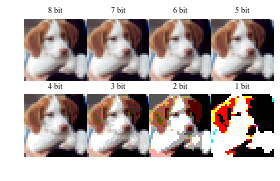

In [39]:
Q = quantize(X[16].unsqueeze(0))
plot_images(Q, 2, 4)

In [31]:
from ingredients.quantize import floyd_steinberg_dither, quantize, batch_dither
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

In [32]:
def quantize_d(x):
    pilimg = tensor2pil(x)
    x7 = floyd_steinberg_dither(pilimg, 7)
    x7 = pil2tensor(x7).unsqueeze(0)
    x6 = floyd_steinberg_dither(pilimg, 6)
    x6 = pil2tensor(x6).unsqueeze(0)
    x5 = floyd_steinberg_dither(pilimg, 5)
    x5 = pil2tensor(x5).unsqueeze(0)
    x4 = floyd_steinberg_dither(pilimg, 4)
    x4 = pil2tensor(x4).unsqueeze(0)
    x3 = floyd_steinberg_dither(pilimg, 3)
    x3 = pil2tensor(x3).unsqueeze(0)
    x2 = floyd_steinberg_dither(pilimg, 2)
    x2 = pil2tensor(x2).unsqueeze(0)
    x1 = floyd_steinberg_dither(pilimg, 1)
    x1 = pil2tensor(x1).unsqueeze(0)
    x = x.unsqueeze(0)
    return torch.cat([x, x7, x6, x5, x4, x3, x2, x1], dim=0)

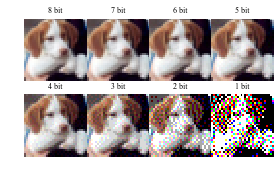

In [35]:
D = quantize_d(X[16])
plot_images(D, 2, 4)

In [24]:
def pgd_linf(model, inputs, targets, eps, step_size):
    ori = inputs.clone()
    for _ in range(20):
        inputs = inputs.clone().detach().requires_grad_(True)
        outputs = model(inputs)
        losses = nn.CrossEntropyLoss(reduction='none')(outputs, targets)
        loss = torch.mean(losses)
        grad, = torch.autograd.grad(loss, [inputs])
        with torch.no_grad():
            inputs = torch.sign(grad) * step_size + inputs
            inputs = torch.clamp(inputs, 0, 1)
            diff = inputs - ori
            diff = torch.clamp(diff, -eps, eps)
            inputs = diff + ori
    return inputs.clone().detach(), diff

In [26]:
model = resnet20().to(device)
model.load_state_dict(torch.load('trained-models/resnet20-1bit-dither.pt'))

Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Sequential
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
LambdaLayer
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Sequential
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
LambdaLayer
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Sequential
Linear
ResNet


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [30]:
X, y = X.to(device), y.to(device)
P, delta = pgd_linf(model, X, y, 8/255, 2/255)

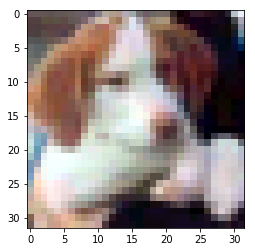

In [32]:
plt.imshow(P[16].cpu().numpy().transpose(1, 2, 0))

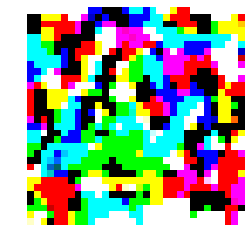

In [41]:
plt.imshow((delta[16]*100).detach().clamp(0, 1).cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.savefig('epsilon-100.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

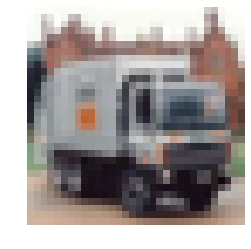

In [55]:
plt.imshow(X[11].cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.savefig('x11.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

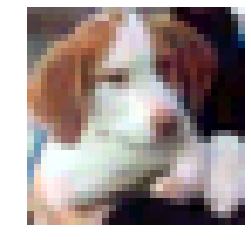

In [43]:
plt.imshow(P[16].cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.savefig('x16a.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

In [45]:
dither = batch_dither(X, 1)

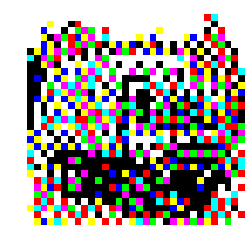

In [56]:
plt.imshow(dither[11].cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.savefig('x11dith.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

In [52]:
dither = dither.to(device)
P_dither, delta = pgd_linf(model, dither, y, 8/255, 2/255)

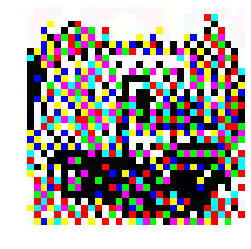

In [58]:
plt.imshow(P_dither[11].cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.savefig('x11dithadv.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

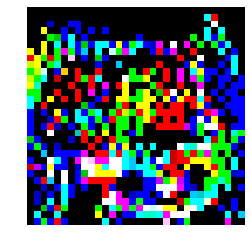

In [57]:
plt.imshow((delta[11]*100).detach().clamp(0, 1).cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.savefig('x11-noise.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

In [60]:
D2 = batch_dither(dither, 1)

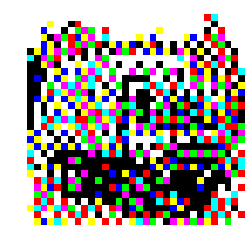

In [61]:
plt.imshow(D2[11].cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.savefig('x11dith2.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)